## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)

import matplotlib.patches as patches

/Users/rok/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import spark_fof
reload(spark_fof)
from spark_fof import Particle, groupID, get_bin, set_local_group

In [4]:
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))
    
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)

## Set up data

In [5]:
data = []
data.append(Particle(-.35,-.35,0,groupID(1,1)))
data.append(Particle(-.27,-.27,1,groupID(1,1)))
data.append(Particle(-.23,-.23,2,groupID(1,1)))
data.append(Particle(-.19,-.19,3,groupID(1,1)))
data.append(Particle(-.01,-.01,4,groupID(1,1)))
data.append(Particle(0.01,0.01,5,groupID(1,1)))
data.append(Particle(0.23,0.23,6,groupID(1,1)))
data.append(Particle(0.29,0.29,7,groupID(1,1)))
data.append(Particle(0.49,0.49,8,groupID(1,1)))
data.append(Particle(0.51,0.51,9,groupID(1,1)))

## Start Spark

In [6]:
import findspark
findspark.init()

In [7]:
import pyspark
from pyspark import SparkContext

In [8]:
sc = SparkContext(master='local[4]')

In [9]:
sc.addPyFile('spark_fof.py')

## Set up the domains

In [10]:
N = 3
tau = 0.05
mins = [-1,-1]
maxes= [1,1]
domain_containers = spark_fof.setup_domain(N,tau)

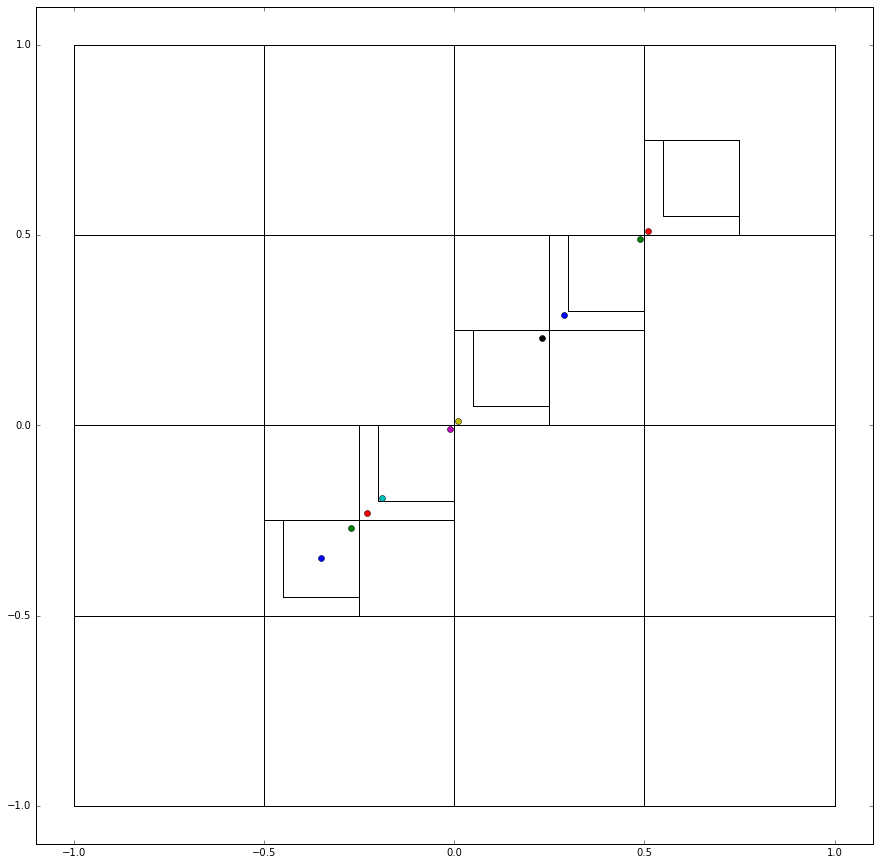

In [11]:
f, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(15,15))
#plot_rectangle(domain_containers[0].bufferRectangle, ax=ax)
for p in data: 
    plot_rectangle(domain_containers[get_bin(p.x, p.y, 2**N, mins,maxes)], ax=ax)
    plot_rectangle(domain_containers[get_bin(p.x, p.y, 2**N, mins,maxes)].bufferRectangle, ax=ax)
    ax.plot(p.x, p.y, 'o')
for r in domain_containers: 
    plot_rectangle(r.parent, ax=ax)

### Make the base RDD

In [12]:
p_rdd = sc.parallelize(data)

In [13]:
p_rdd.collect()

[x=-0.35 y=-0.35 pid=0 gid=(id=1 cid=1),
 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=1),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=1),
 x=-0.19 y=-0.19 pid=3 gid=(id=1 cid=1),
 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=1),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=1),
 x=0.23 y=0.23 pid=6 gid=(id=1 cid=1),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=1),
 x=0.49 y=0.49 pid=8 gid=(id=1 cid=1),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=1)]

### Partition particles into domains and set the partition part of local group ID

In [14]:
# partitioning duplicates the particles that are located in the boundary regions
part_rdd = (p_rdd.mapPartitions(lambda particles: spark_fof.partition_particles(particles, domain_containers, tau))
                 .partitionBy(len(domain_containers))
                 .values()
                 .mapPartitionsWithIndex(set_local_group))

#### Check the partitioned RDD -- some of the particles will be duplicated

In [15]:
parts = part_rdd.collect()

In [16]:
for i,p in enumerate(parts): 
    print i, p

0 x=-0.35 y=-0.35 pid=0 gid=(id=1 cid=18)
1 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=18)
2 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=18)
3 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=19)
4 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=26)
5 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=27)
6 x=-0.19 y=-0.19 pid=3 gid=(id=1 cid=27)
7 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=27)
8 x=0.01 y=0.01 pid=5 gid=(id=1 cid=27)
9 x=0.01 y=0.01 pid=5 gid=(id=1 cid=28)
10 x=0.01 y=0.01 pid=5 gid=(id=1 cid=35)
11 x=0.01 y=0.01 pid=5 gid=(id=1 cid=36)
12 x=0.23 y=0.23 pid=6 gid=(id=1 cid=36)
13 x=0.29 y=0.29 pid=7 gid=(id=1 cid=36)
14 x=0.29 y=0.29 pid=7 gid=(id=1 cid=37)
15 x=0.29 y=0.29 pid=7 gid=(id=1 cid=44)
16 x=0.29 y=0.29 pid=7 gid=(id=1 cid=45)
17 x=0.49 y=0.49 pid=8 gid=(id=1 cid=45)
18 x=0.51 y=0.51 pid=9 gid=(id=1 cid=45)
19 x=0.51 y=0.51 pid=9 gid=(id=1 cid=46)
20 x=0.51 y=0.51 pid=9 gid=(id=1 cid=53)
21 x=0.51 y=0.51 pid=9 gid=(id=1 cid=54)


### Group Merging stage

#### Ugly hack to create a 'fake' data set to look like what we would get out of a first FOF pass

In [17]:
data_partitions = []
for p in parts: 
    data_partitions.append(p.gid.partition)

In [18]:
fof_rdd = sc.parallelize(zip(data_partitions, parts)).partitionBy(len(domain_containers)).values()

In [19]:
fof_rdd.collect()

[x=-0.35 y=-0.35 pid=0 gid=(id=1 cid=18),
 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=18),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=18),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=19),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=26),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=27),
 x=-0.19 y=-0.19 pid=3 gid=(id=1 cid=27),
 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=27),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=27),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=28),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=35),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=36),
 x=0.23 y=0.23 pid=6 gid=(id=1 cid=36),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=36),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=37),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=44),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=45),
 x=0.49 y=0.49 pid=8 gid=(id=1 cid=45),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=45),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=46),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=53),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=54)]

In [20]:
mappings_list = []

In [21]:
fof_analyzer = spark_fof.FOFAnalyzer(sc, N, tau, fof_rdd)

In [22]:
merged_rdd = fof_analyzer.merge_groups(0)

In [23]:
merged_rdd.collect()

[x=-0.35 y=-0.35 pid=0 gid=(id=1 cid=18),
 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=18),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=18),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=18),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=18),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=18),
 x=-0.19 y=-0.19 pid=3 gid=(id=1 cid=18),
 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=18),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=18),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=18),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=18),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=18),
 x=0.23 y=0.23 pid=6 gid=(id=1 cid=18),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=18),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=18),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=18),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=18),
 x=0.49 y=0.49 pid=8 gid=(id=1 cid=18),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=18),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=18),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=18),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=18)]

In [24]:
fof_analyzer.particle_rdd.collect()

[x=-0.35 y=-0.35 pid=0 gid=(id=1 cid=18),
 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=18),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=18),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=19),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=26),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=27),
 x=-0.19 y=-0.19 pid=3 gid=(id=1 cid=27),
 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=27),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=27),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=28),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=35),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=36),
 x=0.23 y=0.23 pid=6 gid=(id=1 cid=36),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=36),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=37),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=44),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=45),
 x=0.49 y=0.49 pid=8 gid=(id=1 cid=45),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=45),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=46),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=53),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=54)]

## try get_bin with cython

In [27]:
import numpy as np
# import pyximport
# pyximport.install(setup_args={"include_dirs":np.get_include()},
#                   reload_support=True)

In [29]:
xs = np.random.rand(1000000)
ys = np.random.rand(1000000)

### Setup cython on workers

looks like some helpful info here: https://www.4info.com/Blog/October-2014/Enhancing-Spark-with-IPython-Notebook-and-Cython

In [30]:
sc.addPyFile('spark_fof_c.pyx')
sc.addPyFile('spark_util.py')

In [31]:
import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()})   

(None, <pyximport.pyximport.PyxImporter at 0x1186a5750>)

In [32]:
from spark_util import spark_cython

In [59]:
def get_particle_bin(p):
    from spark_util import spark_cython
    return spark_cython('spark_fof_c', 'get_bin_cython')(p.x,p.y,100,-1,-1,1,1)

def get_particle_bin_partition(particles, n):
    xs = np.zeros(n)
    ys = np.zeros(n)
    bins = np.zeros(n)
    
    for i, p in enumerate(particles): 
        xs[i]=p.x
        xs[i]=p.y
    
    spark_cython('spark_fof_c', 'get_particle_bins_cython')(xs,ys,bins)
    
    for bin in bins: yield bin

def get_particle_bin_python(p):
    return get_bin(p.x,p.y,100,[-1,-1],[1,1])

In [40]:
%time p_rdd.map(get_particle_bin).take(10)

CPU times: user 6.08 ms, sys: 2.34 ms, total: 8.42 ms
Wall time: 34.8 ms


[3232, 3636, 3838, 4040, 4949, 5050, 6161, 6464, 7474, 7575]

In [41]:
%time p_rdd.map(get_particle_bin_python).take(10)

CPU times: user 5.7 ms, sys: 2.37 ms, total: 8.08 ms
Wall time: 41.3 ms


[3232, 3636, 3838, 4040, 4949, 5050, 6161, 6464, 7474, 7575]

In [42]:
from spark_fof import Particle, groupID

In [43]:
p_arr = []

for i, (x,y) in enumerate(zip(np.random.rand(1000000), np.random.rand(1000000))):
    p_arr.append(Particle(x,y,i,groupID(0,0)))

In [44]:
p_arr_rdd = sc.parallelize(p_arr).cache()

In [45]:
p_arr_rdd.count()

1000000

In [46]:
%time p_arr_rdd.map(get_particle_bin).count()

CPU times: user 4.31 ms, sys: 2.02 ms, total: 6.33 ms
Wall time: 2.78 s


1000000

In [47]:
%time p_arr_rdd.map(get_particle_bin_python).count()

CPU times: user 4.08 ms, sys: 1.91 ms, total: 6 ms
Wall time: 2.59 s


1000000

In [48]:
n = len(p_arr)

In [49]:
list(get_particle_bin_partition(p_arr,n))

[array([ 5098.,  5054.,  5058., ...,  5065.,  5082.,  5084.])]

In [63]:
%time p_arr_rdd.mapPartitions(lambda particles: get_particle_bin_partition(particles, n)).take(100)

CPU times: user 3.49 ms, sys: 1.62 ms, total: 5.1 ms
Wall time: 1.48 s


[5098.0,
 5054.0,
 5058.0,
 5051.0,
 5069.0,
 5079.0,
 5057.0,
 5092.0,
 5076.0,
 5069.0,
 5067.0,
 5087.0,
 5083.0,
 5097.0,
 5094.0,
 5098.0,
 5087.0,
 5073.0,
 5072.0,
 5066.0,
 5065.0,
 5089.0,
 5066.0,
 5061.0,
 5080.0,
 5064.0,
 5078.0,
 5065.0,
 5071.0,
 5077.0,
 5070.0,
 5079.0,
 5052.0,
 5056.0,
 5077.0,
 5057.0,
 5069.0,
 5085.0,
 5051.0,
 5091.0,
 5088.0,
 5071.0,
 5070.0,
 5054.0,
 5083.0,
 5097.0,
 5072.0,
 5090.0,
 5083.0,
 5083.0,
 5093.0,
 5091.0,
 5077.0,
 5075.0,
 5065.0,
 5058.0,
 5089.0,
 5057.0,
 5078.0,
 5057.0,
 5063.0,
 5099.0,
 5084.0,
 5070.0,
 5068.0,
 5062.0,
 5076.0,
 5092.0,
 5051.0,
 5091.0,
 5061.0,
 5082.0,
 5077.0,
 5091.0,
 5064.0,
 5086.0,
 5062.0,
 5053.0,
 5066.0,
 5050.0,
 5073.0,
 5084.0,
 5061.0,
 5072.0,
 5093.0,
 5090.0,
 5085.0,
 5069.0,
 5088.0,
 5051.0,
 5074.0,
 5063.0,
 5098.0,
 5072.0,
 5093.0,
 5058.0,
 5073.0,
 5088.0,
 5054.0,
 5050.0]